In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningModule, Trainer
from sklearn.model_selection import train_test_split

import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import colorsys

import cv2
import os

%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
from services.service import visualize_bbox, visualize
from services.augmentations import get_training_augmentation, get_val_augmentation
from services.model import FasterRCNN, DetectionDataset, collate_fn


BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White

In [4]:
data = pd.read_csv('my_data.csv', )
data

image  xmin  ymin  xmax  \
0      /root/workspace/work/Digital-Tashkent/Signs/da...  1764   320  1917   
1      /root/workspace/work/Digital-Tashkent/Signs/da...  1750   384  1937   
2      /root/workspace/work/Digital-Tashkent/Signs/da...  1098   549  1151   
3      /root/workspace/work/Digital-Tashkent/Signs/da...  1570   616  1635   
4      /root/workspace/work/Digital-Tashkent/Signs/da...  1666   511  1764   
...                                                  ...   ...   ...   ...   
12964  /root/workspace/work/Digital-Tashkent/Signs/da...  1754   461  1828   
12965  /root/workspace/work/Digital-Tashkent/Signs/da...  1775   542  1822   
12966  /root/workspace/work/Digital-Tashkent/Signs/da...  2003   253  2109   
12967  /root/workspace/work/Digital-Tashkent/Signs/da...  2042   378  2116   
12968  /root/workspace/work/Digital-Tashkent/Signs/da...  1696   534  1763   

       ymax    name                 class  
0       385    5.33    Informational_sign  
1       592     2.1         Priority_sign  
2       595     2.1         Priority_sign  
3       681  5.16.2    Informational_sign  
4       608  5.16.2    Informational_sign  
...     ...     ...                   ...  
12964   541    3.27       Forbidding_sign  
12965   626   7.2.3  Additional_info_sign  
12966   380    3.27       Forbidding_sign  
12967   513   7.2.3  Additional_info_sign  
12968   605  5.16.2    Informational_sign  

[12969 rows x 7 columns]

<AxesSubplot: >

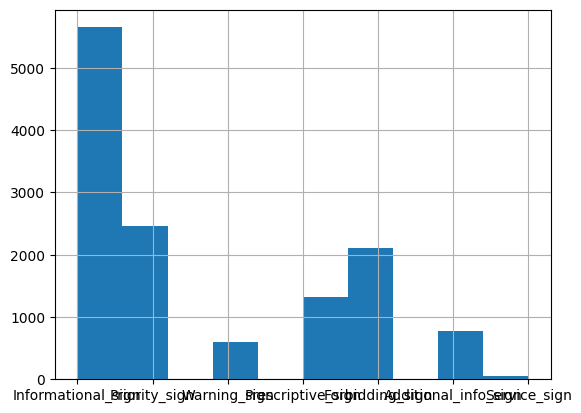

In [5]:
data['class'].hist()

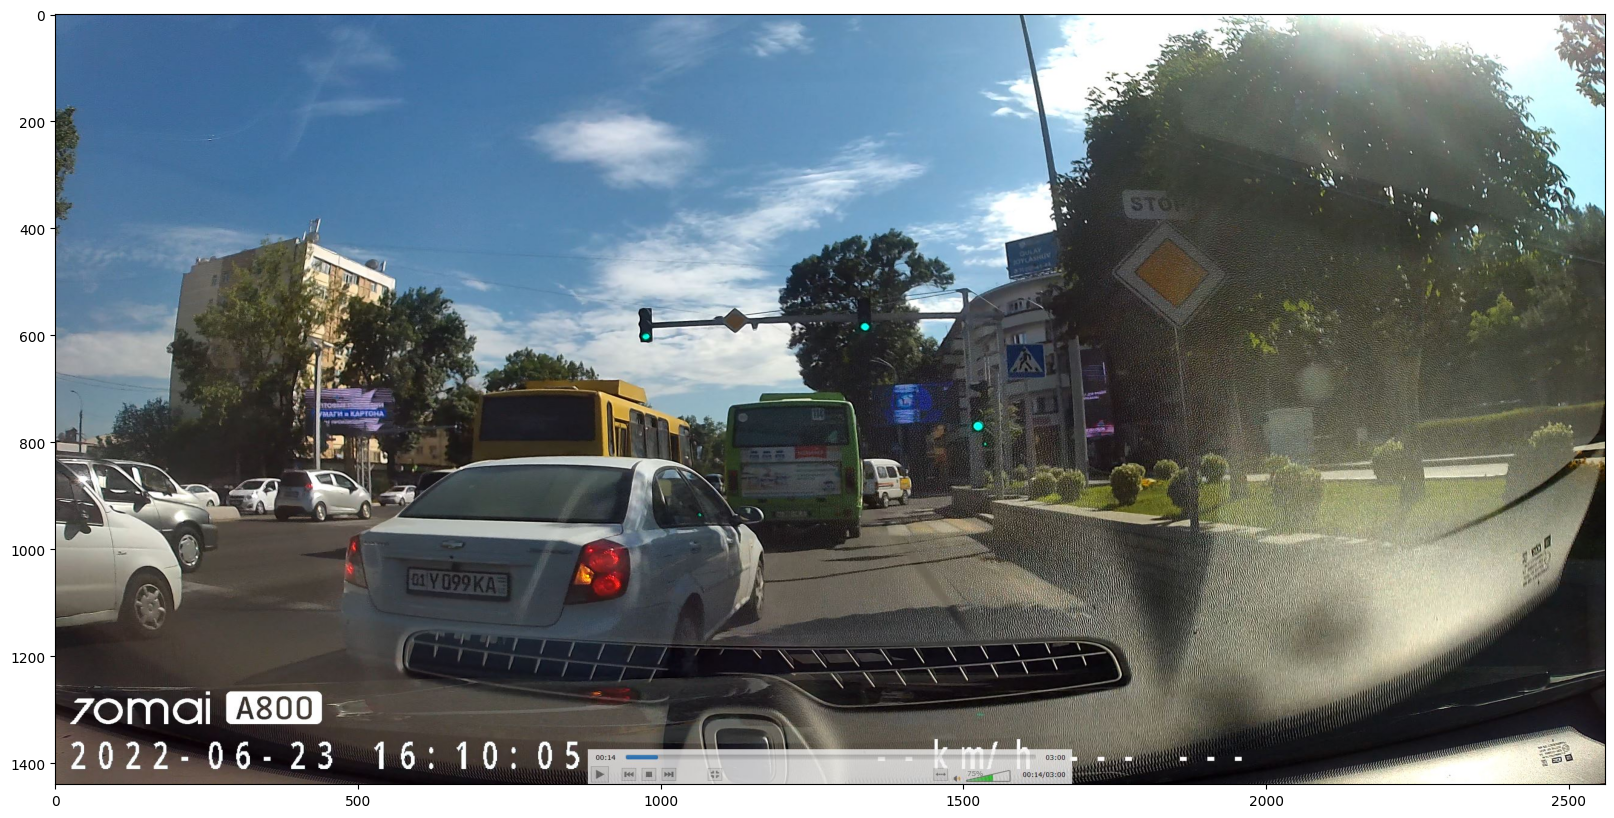

In [6]:
im = cv2.imread(data['image'][0])
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(20, 10))
plt.imshow(im, aspect='auto')

In [7]:
uniq = data['class'].unique()
len_uniq = len(uniq) + 1
range_uniq = range(1, len_uniq + 1)
str_to_num = dict(zip(uniq, range_uniq))
num_to_str = dict(zip(range_uniq, uniq))
str_to_num, num_to_str

({'Informational_sign': 1,
  'Priority_sign': 2,
  'Warning_sign': 3,
  'Prescriptive_sign': 4,
  'Forbidding_sign': 5,
  'Additional_info_sign': 6,
  'Service_sign': 7},
 {1: 'Informational_sign',
  2: 'Priority_sign',
  3: 'Warning_sign',
  4: 'Prescriptive_sign',
  5: 'Forbidding_sign',
  6: 'Additional_info_sign',
  7: 'Service_sign'})

In [8]:
def get_num(label):
    return str_to_num[label]

In [9]:
data['class'] = data['class'].apply(get_num)
data.head()

image  xmin  ymin  xmax  ymax  \
0  /root/workspace/work/Digital-Tashkent/Signs/da...  1764   320  1917   385   
1  /root/workspace/work/Digital-Tashkent/Signs/da...  1750   384  1937   592   
2  /root/workspace/work/Digital-Tashkent/Signs/da...  1098   549  1151   595   
3  /root/workspace/work/Digital-Tashkent/Signs/da...  1570   616  1635   681   
4  /root/workspace/work/Digital-Tashkent/Signs/da...  1666   511  1764   608   

     name  class  
0    5.33      1  
1     2.1      2  
2     2.1      2  
3  5.16.2      1  
4  5.16.2      1

<AxesSubplot: ylabel='Frequency'>

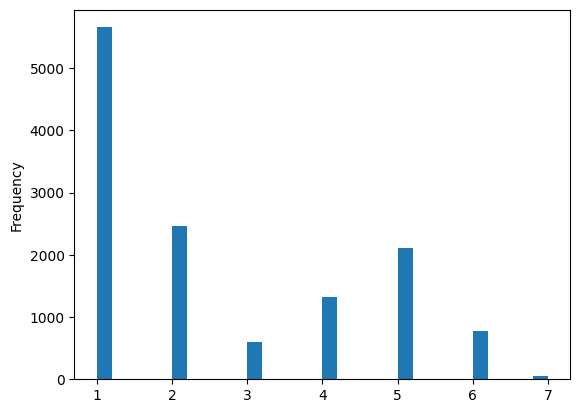

In [10]:
data['class'].plot.hist(bins=30)

In [11]:
train, val = train_test_split(data, test_size=0.30, stratify=data['class'])
train.reset_index(inplace=True, drop=True)
train = train['image'].unique()
val.reset_index(inplace=True, drop=True)
val = val['image'].unique()


In [12]:
transform_train = get_training_augmentation(960, 1080)
tranfrorm_val = get_val_augmentation(960, 1080)

In [13]:
train_set = DetectionDataset(data, train, '',
                             transform_train
                             )
val_set = DetectionDataset(data, val, '',
                           tranfrorm_val
                           )

In [14]:
im, targets = val_set[40]
im.shape, targets, targets['boxes'].numpy()

(torch.Size([3, 1080, 960]),
 {'boxes': tensor([[666.0000, 397.0924, 713.2500, 497.6994],
          [535.1250, 564.0085, 549.3750, 606.6902]]),
  'labels': tensor([1, 1])},
 array([[666.     , 397.09244, 713.25   , 497.69937],
        [535.125  , 564.0085 , 549.375  , 606.6902 ]], dtype=float32))

In [15]:
TO_NAME = {0: 'Informational_sign',
  1: 'Warning_sign',
  2: 'Forbidding_sign',
  3: 'Additional_info_sign',
  4: 'Priority_sign',
  5: 'Prescriptive_sign',
  6: 'Service_sign'}

N = len(TO_NAME)
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = list(map(lambda x: (np.array(colorsys.hsv_to_rgb(*x))).tolist(), HSV_tuples))
TO_COLOR = dict(zip(range(N), RGB_tuples))

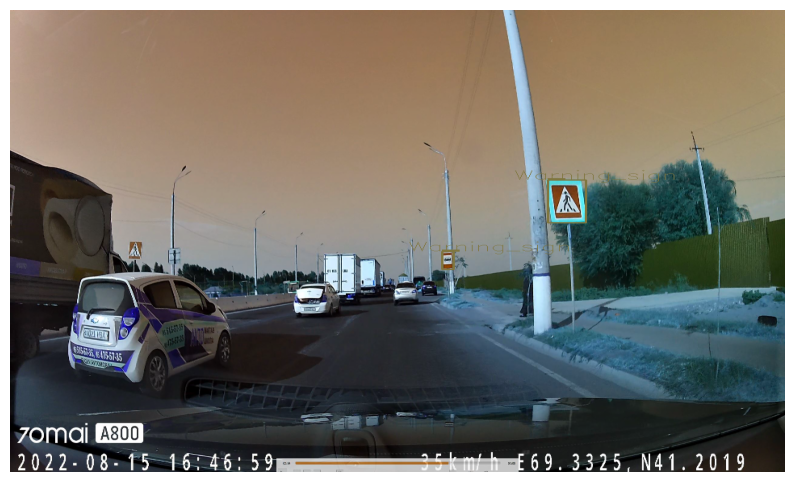

In [16]:
visualize(im.permute(1, 2, 0).float().numpy(), targets['boxes'].numpy(), targets['labels'].numpy(), TO_NAME, TO_COLOR)

In [17]:
data_loader = torch.utils.data.DataLoader(
    train_set, batch_size=24, shuffle=True, num_workers=24, collate_fn=collate_fn,
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=24, num_workers=24, collate_fn=collate_fn,
)

In [18]:
det_model = FasterRCNN(len_uniq)

In [19]:
# det_model = torch.compile(det_model)

In [20]:
from pytorch_lightning.callbacks import ModelCheckpoint
path_loc = f'{len_uniq}class_v1'
checkpoint_callback = ModelCheckpoint(
    dirpath=f"../lightning_logs/detection/{path_loc}", save_top_k=2, monitor="val_epoch_total_step", mode='max')


In [21]:
trainer = Trainer(accelerator='gpu', devices=1,
                  max_epochs=100,
                  precision=16,
                  callbacks=[checkpoint_callback],
                  default_root_dir=f'../lightning_logs/detection/{path_loc}'
                  )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(det_model,
            data_loader, val_loader,
            )

Missing logger folder: ../lightning_logs/detection/8class_v1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | detector | FasterRCNN           | 43.3 M
1 | metric   | MeanAveragePrecision | 0     
--------------------------------------------------
43.1 M    Trainable params
225 K     Non-trainable params
43.3 M    Total params
86.574    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/root/miniconda3/envs/sign-rec/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/root/miniconda3/envs/sign-rec/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [23]:
det_model = det_model.to('cpu')

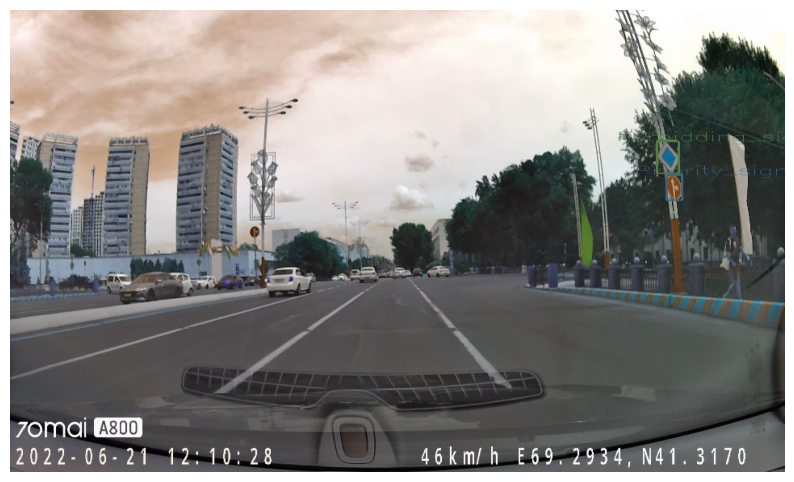

In [25]:
im,targets = val_set[124]
visualize(im.permute(1, 2, 0).float().numpy(), targets['boxes'].numpy(), targets['labels'].numpy(), TO_NAME, TO_COLOR)

In [27]:
ret = det_model([im.float()])

In [28]:
ret[0]

{'boxes': tensor([[802.1512, 310.2409, 830.0706, 381.0045],
         [813.2735, 384.4402, 832.8822, 444.5841],
         [295.6805, 505.2382, 309.8082, 533.4907],
         [818.3781, 442.2010, 827.6378, 491.9628],
         [258.6861, 264.2047, 283.0209, 376.6560],
         [893.2220, 594.9703, 904.6285, 635.0466],
         [296.2000, 504.7259, 309.6708, 533.6115],
         [735.7525, 560.1555, 743.7308, 603.4740],
         [309.3884, 573.4969, 320.1139, 621.6061],
         [894.0355, 596.4326, 904.1176, 634.5387]], grad_fn=<StackBackward0>),
 'labels': tensor([2, 4, 4, 6, 3, 5, 5, 4, 4, 4]),
 'scores': tensor([0.9978, 0.9754, 0.8978, 0.3175, 0.1810, 0.1157, 0.0898, 0.0845, 0.0702,
         0.0533], grad_fn=<IndexBackward0>)}

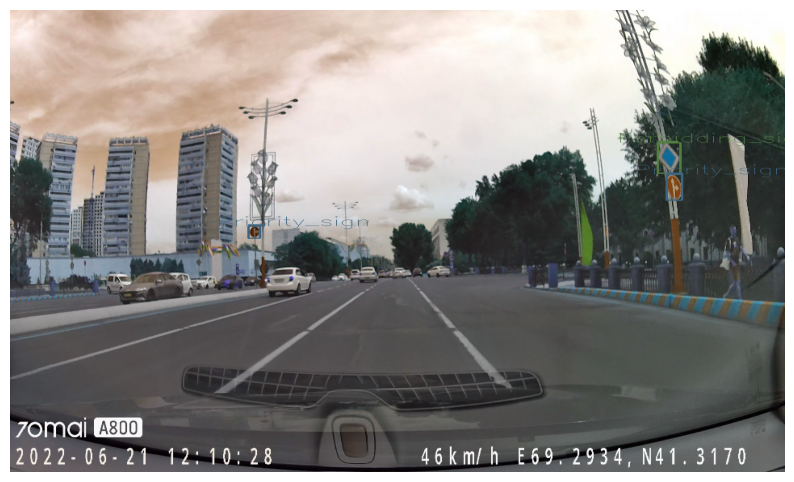

In [34]:
j = 3
visualize(im.permute(1, 2, 0).float().detach().numpy(), ret[0]['boxes'].detach().numpy()[:j], ret[0]['labels'].detach().numpy()[:j], TO_NAME, TO_COLOR)

In [36]:
script = torch.jit.script(det_model.detector)
# save for use in production environment
torch.jit.save(script, "mymodel_det.pt")
